In [1]:
!nvidia-smi

Tue Apr 25 11:32:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q albumentations==1.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 5.9 MB/s eta 0:00:00


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import cv2
import PIL
import math
from PIL import Image as img
from tqdm import tqdm
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import albumentations as A
cuda = torch.cuda.is_available()
import datetime
import seaborn as sns
from pathlib import Path
from torchsummary import summary
sns.set()
from tqdm.auto import tqdm
from torchvision.utils import save_image

In [4]:
class Albumentations_transform:
  """
  Class to create test and train transforms using Albumentations. ToTensor() will be appended at the end of transforms list
  """
  def __init__(self, transforms_list=[]):
      self.transforms = A.Compose(transforms_list)

  """
  Library works only with named arguments and numpy array. Hence to make it compatible with torchvision, using wrapper to convert to np array
  """
  def __call__(self, img):
      img = np.array(img)
      img = self.transforms(image=img)['image']  # if ['image'] is not given, then it will give key error in dataloader
      img = np.transpose(img, (2,0,1))
      return img  

In [5]:
if cuda:
    torch.cuda.manual_seed(1)

dataloader_args = dict(shuffle=True, batch_size=512, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

channels_mean  = [0.49139968, 0.48215841, 0.44653091]
channels_stdev = [0.24703223, 0.24348513, 0.26158784]


test_transforms   = Albumentations_transform([A.Normalize(mean=channels_mean, std=channels_stdev),])
train_transforms  = Albumentations_transform([A.Normalize(mean=channels_mean, std=channels_stdev),
                                              A.Sequential([A.PadIfNeeded(min_height=40, min_width=40, border_mode=cv2.BORDER_CONSTANT, value=(0.49139968, 0.48215841, 0.44653091)),
                                                            A.RandomCrop(32, 32)], p=1.0), 
                                              A.HorizontalFlip(),                                             
                                              A.Cutout(num_holes=1, max_h_size=16, max_w_size=16, fill_value=channels_mean),                                              
                                              ])

train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data  = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

# train dataloader
trainloader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
testloader = torch.utils.data.DataLoader(test_data, **dataloader_args)

/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/transforms.py:643: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


100%|██████████| 170498071/170498071 [00:05<00:00, 29517788.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
len(trainloader)

98

In [7]:
# Function to unnormalize and bring back to original pixel values. Transpose is to reshape the image on x & y axes and make it ready for display
def unnormalize(img):
    for i in range(img.shape[0]):
        img[i] = (img[i]*channels_stdev[i])+channels_mean[i]
    img = img.permute(1, 2, 0)
    return img

images.size() : torch.Size([512, 3, 32, 32]), labels.size() : torch.Size([512])


(-0.5, 171.5, 341.5, -0.5)

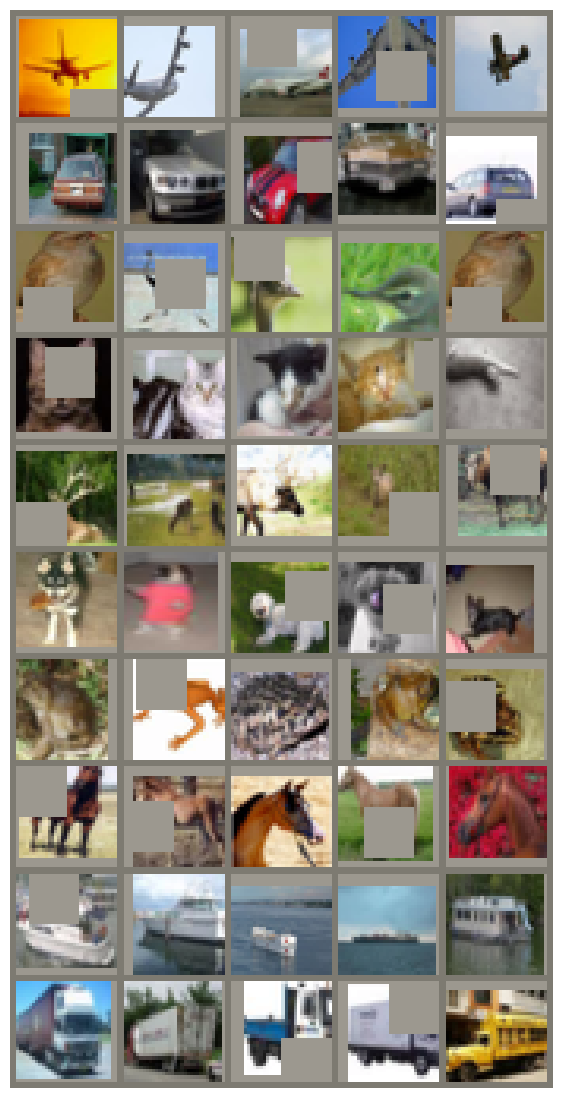

In [8]:
images, labels = next(iter(trainloader))
print(f'images.size() : {images.size()}, labels.size() : {labels.size()}')
num_classes = 10
num_images  = 5
fig_name    = 'Train_Images'
lst = []
fig = plt.figure(figsize=(14,14))
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], num_images)
    lst.extend(images[idx])
disp_grid = torchvision.utils.make_grid(lst, 5)
disp_grid1 = unnormalize(disp_grid)

plt.imshow(disp_grid1)
plt.axis('off')

# CIFAR10 - VAE

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Build the Models

In [10]:
class Encoder(nn.Module):
    """
    Creates the Encoder

    nc (int): number of channels of the input image
    ndf (int): number of feature maps for the discriminator

    This uses the special Spectral Normalization ref: https://arxiv.org/abs/1802.05957
    """
    def __init__(self, nc: int = 3, ndf: int = 16, z_dim: int = 20):
        super(Encoder, self).__init__()

        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            torch.nn.utils.spectral_norm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 2, 10, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (10) x 4 x 4
        )

        self.expand_fc  = nn.Conv2d(20, ndf *2, kernel_size=1)
        self.gap = nn.AdaptiveAvgPool2d(1) # 10 x 1 x 1        

        self.mu = nn.Conv2d(ndf * 2, z_dim, 1, bias=False)
        self.logvar = nn.Conv2d(ndf * 2, z_dim, 1, bias=False)

    def forward(self, input, one_hot_label):
        # one_hot_label = one_hot_label.squeeze(1)
        out = self.main(input)
        out = self.gap(out)    # B x 10 x 1 x 1 
        out = out.view(-1, 10) # B x 10 
        out = torch.cat((out, one_hot_label), dim=1)  # B x 20
        out = out.unsqueeze(-1).unsqueeze(-1)     # B x 20 x 1 x 1
        out = self.expand_fc(out)  # B x (ndf * 2) x 1 x 1
        mu = self.mu(out)
        logvar = self.logvar(out)
        return mu, logvar

In [11]:
class Decoder(nn.Module):
    """
    Creates the Decoder

    nc (int): channels in the final output
    nz (int): size of the latent z vector
    ngf (int): number of feature maps for the generator
    """
    def __init__(self, nc: int = 3, ngf: int = 16, z_dim: int = 20):
        super(Decoder, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, nc, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nc),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.Tanh()
        )

    def forward(self, input):
        decoder_out = self.main(input)
        return decoder_out

In [12]:
class cifar10VAE(nn.Module):
    def __init__(self, nc: int = 3, nf: int = 8, z_dims: int = 20):
        super(cifar10VAE, self).__init__()

        self.encoder = Encoder(nc, nf, z_dims)
        self.decoder = Decoder(nc, nf * 2, z_dims)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def reparam_like_train(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, input, one_hot_label):
        mu, logvar = self.encoder(input, one_hot_label)
        z = self.reparameterize(mu, logvar)
        out = self.decoder(z)

        return out, mu, logvar


In [13]:
cifar10VAE = cifar10VAE(nc=3, nf=32, z_dims=1024).to(device)

In [14]:
input = torch.randn(1, 3, 32, 32).to(device)
one_hot_label = torch.randn(1, 10).to(device)
[x.shape for x in cifar10VAE(input, one_hot_label)]

[torch.Size([1, 3, 32, 32]),
 torch.Size([1, 1024, 1, 1]),
 torch.Size([1, 1024, 1, 1])]

In [15]:
def vae_gaussian_kl_loss(mu, logvar):
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

    return KLD.mean()

def reconstruction_loss(x_reconstructed, x):
    return torch.sum(F.mse_loss(x_reconstructed, x, reduction='none'), dim=(1, 2, 3)).mean()

def kl_divergence_loss(mean, logvar):
        return ((mean**2 + logvar.exp() - 1 - logvar) / 2).mean()

def loss_function(y_pred, y_true):

    recon_x, mu, logvar = y_pred

    recon_loss = reconstruction_loss(recon_x, y_true)

    kld_loss = vae_gaussian_kl_loss(mu, logvar)

    return recon_loss + kld_loss


In [16]:
input = torch.randn(32, 3, 32, 32).to(device)
one_hot_label = torch.randn(32, 10).to(device)
y_true = torch.randn(32, 3, 32, 32).to(device)
output = cifar10VAE(input, one_hot_label)
loss = loss_function(output, y_true)
loss

tensor(3691.9465, device='cuda:0', grad_fn=<AddBackward0>)

## Dataset

## Train the Model

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
optimizer = optim.Adam(cifar10VAE.parameters(), lr=1e-4)

In [29]:
def train_epoch(model, optimizer):
    model.train()

    model = model.to(device)

    train_loss = 0

    for batch_idx, (data, label) in enumerate(trainloader):
        data = data.to(device)
        label_one_hot = F.one_hot(label, 10).float().cuda()

        optimizer.zero_grad() # zero out the gradients

        output = model(data, label_one_hot ) # forward pass

        loss = loss_function(output, data) # compute the loss

        loss.backward() # backprop the loss

        train_loss += loss.item()

        optimizer.step() # update the optimizer

        if batch_idx % 50 == 0:
            print(f'Loss={loss.item() :0.4f} Batch={batch_idx}')

    epoch_loss = train_loss / len(trainloader)

    print(f'Train set: Average loss for epoch : {epoch_loss: .4f} len(train_loader) : {len(trainloader)}')
    
    return epoch_loss

In [35]:
NUM_EPOCHS = 150
out_images = Path('vae_output')
out_images.mkdir(parents=True, exist_ok=True)
for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    avg_loss = train_epoch(cifar10VAE, optimizer)
    if epoch % 20 == 0 or epoch == NUM_EPOCHS:
        print(f'=> Epoch: {epoch}\tAverage Loss: {avg_loss:.4f}\n')

  0%|          | 0/150 [00:00<?, ?it/s]

Loss=1752.8850 Batch=0
Loss=1722.6614 Batch=50
Train set: Average loss for epoch :  1765.6243 len(train_loader) : 98
Loss=1837.8405 Batch=0
Loss=1739.4615 Batch=50
Train set: Average loss for epoch :  1766.7663 len(train_loader) : 98
Loss=1753.5630 Batch=0
Loss=1760.0131 Batch=50
Train set: Average loss for epoch :  1769.8445 len(train_loader) : 98
Loss=1829.7833 Batch=0
Loss=1695.2412 Batch=50
Train set: Average loss for epoch :  1766.2670 len(train_loader) : 98
Loss=1803.9679 Batch=0
Loss=1773.9761 Batch=50
Train set: Average loss for epoch :  1762.8442 len(train_loader) : 98
Loss=1787.0282 Batch=0
Loss=1742.9746 Batch=50
Train set: Average loss for epoch :  1763.5906 len(train_loader) : 98
Loss=1814.3975 Batch=0
Loss=1796.4359 Batch=50
Train set: Average loss for epoch :  1763.8747 len(train_loader) : 98
Loss=1696.7235 Batch=0
Loss=1745.8120 Batch=50
Train set: Average loss for epoch :  1759.6253 len(train_loader) : 98
Loss=1726.7153 Batch=0
Loss=1809.4967 Batch=50
Train set: Averag

Let's try to see what the model outputs if we provide it with some random z vector

In [56]:
val_loader = torch.utils.data.DataLoader(test_data, batch_size=32)
def validate(model):
    model.eval()
    with torch.no_grad():
        i = 0
        for data, label in val_loader:
            i += 1
            if i > 0:
                break
        print(label)
        data = data.float().cuda()
        label_one_hot_val = F.one_hot(label, 10).float().cuda()
        output = model(data, label_one_hot_val)
        save_image(data, '/content/vae_output/data_32' + '.png')
        save_image(output[0].view(32, 3, 32, 32), '/content/vae_output/sample_32_correct' + '.png')

        for lab in label:
            if lab == 9:
                lab -= 1
            else:
                lab += 1         
        
        print(label)
        label_one_hot_val_wrong = F.one_hot(label, 10).float().cuda()
        output_wrong = model(data, label_one_hot_val_wrong)
        save_image(output_wrong[0].view(32, 3, 32, 32), '/content/vae_output/sample_32_wrong' + '.png')   

        return data, output[0], output_wrong[0]

In [57]:
data, out, out_w = validate(cifar10VAE)

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5])
tensor([4, 9, 9, 1, 7, 7, 2, 7, 4, 2, 1, 8, 6, 8, 8, 9, 6, 8, 9, 7, 8, 1, 5, 8,
        6, 3, 5, 1, 8, 7, 7, 6])


In [58]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
unorm = UnNormalize(mean=channels_mean, std=channels_stdev)

In [59]:
def norm_ip(img, min, max):
    img.clamp_(min=min, max=max)
    img.add_(-min).div_(max - min + 1e-5)

def norm_tensor(t):
    norm_ip(t, float(t.min()), float(t.max()))

Display output, when correct labels were fed

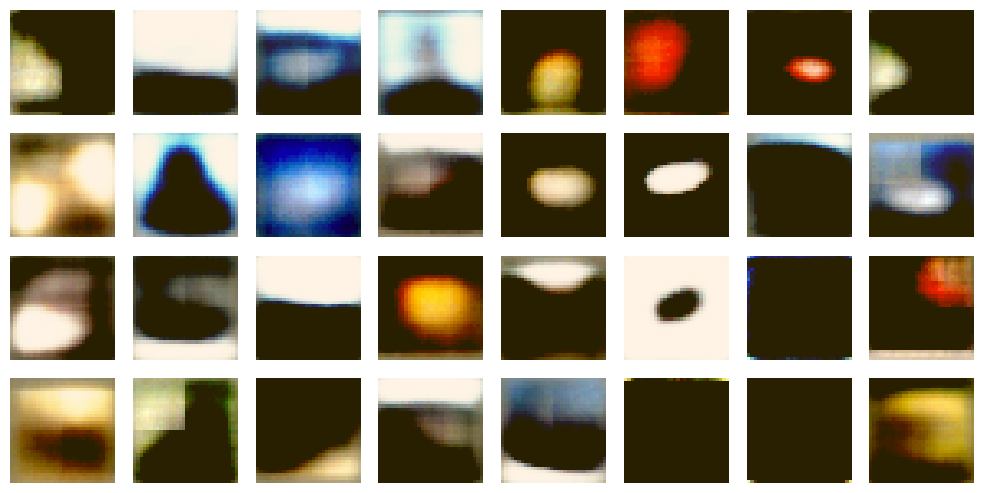

In [67]:
fig = plt.figure(figsize=(10, 10))
for idx, image in enumerate(out[:32]):
    plt.subplot(8, 8, idx+1)
    image.squeeze_(0)
    # image = unorm(image)
    norm_tensor(image)
    plt.imshow(image.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.grid('off')
plt.tight_layout()
fig.canvas.draw()
correct = np.array(fig.canvas.renderer.buffer_rgba())

Display output, when in-correct labels were fed

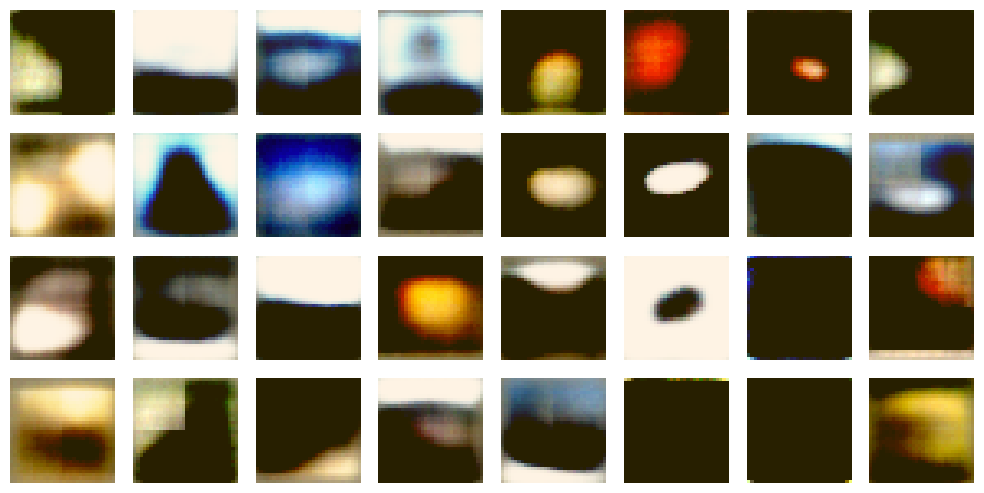

In [68]:
fig = plt.figure(figsize=(10, 10))
for idx, image in enumerate(out_w[:32]):
    plt.subplot(8, 8, idx+1)
    image.squeeze_(0)
    norm_tensor(image)
    # image = unorm(image)
    plt.imshow(image.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.grid('off')
plt.tight_layout()
fig.canvas.draw()
wrong = np.array(fig.canvas.renderer.buffer_rgba())

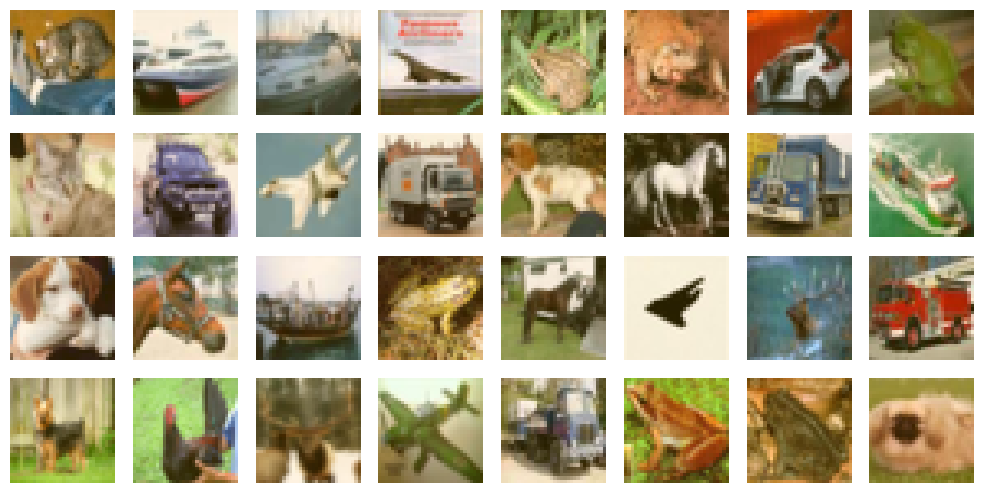

In [70]:
fig = plt.figure(figsize=(10, 10))
for idx, image in enumerate(data[:32]):
    plt.subplot(8, 8, idx+1)
    image.squeeze_(0)
    # image = unorm(image)
    norm_tensor(image)
    plt.imshow(image.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.grid('off')
plt.tight_layout()
fig.canvas.draw()
real = np.array(fig.canvas.renderer.buffer_rgba())

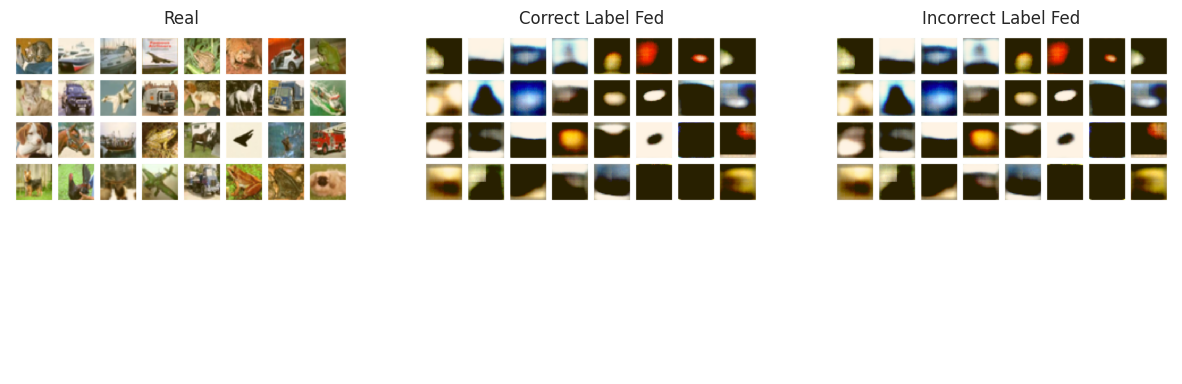

In [71]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(real)
plt.title('Real')
plt.grid('off')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(correct)
plt.title('Correct Label Fed')
plt.grid('off')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(wrong)
plt.title('Incorrect Label Fed')
plt.grid('off')
plt.axis('off')

plt.show()